In [1]:
import ast
import pandas as pd
import numpy as np
import torch
from tensorflow import keras
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from IPython import display
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from torch import tensor

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 250,250



tensor([[2., 3.],
        [4., 5.]])

In [2]:
csv_path = keras.utils.get_file(
    "250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("~/.keras/datasets/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249455 entries, 0 to 249454
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   smiles  249455 non-null  object 
 1   logP    249455 non-null  float64
 2   qed     249455 non-null  float64
 3   SAS     249455 non-null  float64
dtypes: float64(3), object(1)
memory usage: 7.6+ MB


In [4]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br", None]'  #wyrzucić B, Br,  P, I

bond_mapping = {None: 0, "SINGLE": 1, "DOUBLE": 2, "TRIPLE": 3, "AROMATIC": 4}
bond_mapping.update(
    {0: None, 1: BondType.SINGLE, 2: BondType.DOUBLE, 3: BondType.TRIPLE, 4: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)
MAX_BONDNUM = 150
MAX_MOLSIZE = 64 #max(df["smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 32
EPOCHS = 500

VAE_LR = 5e-4
NUM_ATOMS = 32  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 5  # Number of bond types
LATENT_DIM = 256  # Size of the latent space

In [5]:
def edge_idx_to_adj(edge_index, edges_attr):
    #print(edges_attr)
    adj = np.zeros((NUM_ATOMS, NUM_ATOMS))
    attr_matrix = np.zeros((NUM_ATOMS, NUM_ATOMS, BOND_DIM))
    for i in range(edge_index.shape[1]):
        k = edge_index[0][i]
        j = edge_index[1][i]
        adj[k][j] = 1
        attr_matrix[k][j] = edges_attr[i]
    return torch.tensor(adj), torch.tensor(attr_matrix)

def batch_edge_idx_to_adj(edge_index, edges_attr):
    adj = np.zeros((BATCH_SIZE*NUM_ATOMS, BATCH_SIZE*NUM_ATOMS))
    attr_matrix = np.zeros((BATCH_SIZE*NUM_ATOMS,BATCH_SIZE*NUM_ATOMS, BOND_DIM))
    adj_reduced = np.zeros((0, NUM_ATOMS))
    attr_reduced = np.zeros((0, NUM_ATOMS, BOND_DIM))
    for i in range(edge_index.shape[1]):
        k = edge_index[0][i]
        j = edge_index[1][i]
        adj[k][j] = 1
        attr_matrix[k][j] = edges_attr[i]
    for i in range(BATCH_SIZE):
        #print(adj.shape, (adj[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS]).shape)
        adj_reduced = np.concatenate([adj_reduced, adj[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS]], axis=0)
        attr_reduced = np.concatenate([attr_reduced, attr_matrix[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS,:]], axis=0)
    return torch.tensor(adj_reduced), torch.tensor(attr_reduced)

def molecule_to_graph(molecule):
    # Converts SMILES to molecule object
    
    mol_atoms = molecule.GetNumAtoms()    # Initialize adjacency and feature tensor
    num_of_bonds = molecule.GetNumBonds()
    edge_index = [[],[]]
    edge_features = []
    adj_mat = np.zeros((NUM_ATOMS, ATOM_DIM))
    
    features = np.zeros((NUM_ATOMS, ATOM_DIM))

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        atomic_num = atom.GetAtomicNum()
        degree = atom.GetDegree()
        features[atom_idx] = np.eye(ATOM_DIM)[atom_type] #np.concatenate((np.eye(ATOM_DIM)[atom_type][:-2], chem_features), axis=0)
    for i in range(mol_atoms, NUM_ATOMS):
        features[i][ATOM_DIM-1] = 1
        edge_index[0].append(i)
        edge_index[1].append(i)
        edge_embbeding = list(np.eye(BOND_DIM)[BOND_DIM-1])
        edge_features.append(edge_embbeding)
        # loop over one-hop neighbors
    for bond in molecule.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_type_idx = bond_mapping[bond.GetBondType().name]
        edge_index[0] = list(np.append(edge_index[0], [i, j]))
        edge_index[1] = list(np.append(edge_index[1], [j, i]))
        edge_embbeding = list(np.eye(BOND_DIM)[bond_type_idx])
        edge_features.append(edge_embbeding)
        edge_features.append(edge_embbeding)
    return tensor(features), tensor(edge_index), tensor(edge_features)


def graph_to_molecule(graph):  # for edges in adjacency matrix format
    features, adjacency, edge_features = graph

    if adjacency.shape[0] == 2:
       adjacency, edge_features = batch_edge_idx_to_adj(adjacency, edge_features)
    #print(features, adjacency, edge_features)
    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()
    for i in range(len(adjacency)):
        adjacency[i][i] = 0

    # Remove "no atoms" & atoms with no bonds
    mol_idx_to_graph_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (adjacency.sum(axis=1) != 0)
    )
    mol_idx_to_graph_idx = np.squeeze(mol_idx_to_graph_idx)

    graph_idx_to_mol_idx = np.full_like([], fill_value=-1, shape=NUM_ATOMS, dtype=int)
    for mol_idx, graph_idx in enumerate(mol_idx_to_graph_idx):
        graph_idx_to_mol_idx[graph_idx] = mol_idx
    
    for mol_idx, graph_idx in enumerate(mol_idx_to_graph_idx):
        atom_type_idx = int(torch.argmax(features[graph_idx]))
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    for mol_idx_1, graph_idx_1 in enumerate(mol_idx_to_graph_idx):
        for mol_idx_2, graph_idx_2 in enumerate(mol_idx_to_graph_idx):
            if adjacency[graph_idx_1][graph_idx_2] > 0.6 and graph_idx_2 > graph_idx_1:
                #print(edge_features[graph_idx_1][graph_idx_2])
                edge_type_encoded = int(np.argmax(edge_features[graph_idx_1][graph_idx_2]))
                #bond_type = bond_mapping[edge_type_encoded]       
                if edge_type_encoded != 4: molecule.AddBond(int(mol_idx_1), int(mol_idx_2), Chem.BondType.SINGLE)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)

    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        print("Sth went wrong")
        return molecule
    #print("OK")
    return molecule

def adj_to_index(adj_matrix, attr_matrix):
    edge_index=[[], []]
    edge_attr = []
    for i, row in enumerate(adj_matrix):
        adj_matrix[i][i]=0 
        for j in range(len(row)):
            if row[j] == 1:
                edge_index[0].append(i)
                edge_index[1].append(j)
                edge_embedding = attr_matrix[i][j]
                edge_attr.append(edge_embedding)
    return torch.tensor(edge_index), torch.tensor(edge_attr)


def concat_features(features, edge_index, edges_attr):
    if edges_attr.shape[1]==5:
        edges_attr_3d = edge_idx_to_adj(edge_index, edges_attr)[1]
        edges_adj = np.zeros((NUM_ATOMS, NUM_ATOMS), int)
        for i in range(NUM_ATOMS):
            for j in range(NUM_ATOMS):
                edges_adj[i][j]= int(np.argmax(edges_attr_3d[i][j]))
    else: 
        edges_adj = np.zeros((NUM_ATOMS, NUM_ATOMS), int)
        for i in range(NUM_ATOMS):
            for j in range(NUM_ATOMS):
                edges_adj[i][j]= int(np.argmax(edges_attr[i][j]))
    res = torch.cat((torch.Tensor(features), torch.Tensor(edges_adj)), dim=1)
    return res


In [6]:
from sklearn.discriminant_analysis import StandardScaler
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


class Featurizer():
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            smiles = row["smiles"]
            molecule = Chem.MolFromSmiles(smiles)
            if molecule.GetNumAtoms() < 32:
                features, edge_index, edge_attr = molecule_to_graph(molecule) 
                features = concat_features(features, edge_index, edge_attr)
                graphs.append((features, edge_index, edge_attr))
                labels.append(molecule)
            
        return [Data(
            features=features.float(), 
            edge_index=edge_index.int(), 
            edge_attr=edge_attr.float(),
            mol=labels)
            for ((features, edge_index, edge_attr), labels) in zip(graphs, labels)]

In [7]:
import sklearn
from sklearn import model_selection
from torch.utils.data import DataLoader

train_data, test_data = model_selection.train_test_split(df, test_size=0.2)

In [8]:
featurizer = Featurizer()
data_train = featurizer(train_data[:1024])
data_val = featurizer(test_data[:128])

from torch_geometric.loader import DataLoader
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE)
val_loader = DataLoader(data_val, batch_size=BATCH_SIZE)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
def temperature(input, t=1.0):
  return input/t

In [12]:
def get_edge_bin(edges_attr):
    edges_adj = torch.zeros(size=(NUM_ATOMS, NUM_ATOMS))
    for i in range(NUM_ATOMS):
        for j in range(NUM_ATOMS):
            if np.argmax(edges_attr[i][j]) > 0:
                edges_adj[i][j] = 1
    return edges_adj

In [26]:
from torch_geometric.nn import GATConv, global_mean_pool
#import torch.nn.functional as F
from torch.nn.functional import dropout, one_hot
import torch


HIDDEN_SIZE=512

class Encoder(torch.nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)

        self.conv = [
            GATConv(atom_dim+NUM_ATOMS, hidden_size),
            #GATConv(hidden_size, hidden_size),
            #GATConv(hidden_size, hidden_size),
            #GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size)
        ]
        self.pooling = global_mean_pool
        self.dense = [
            torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        ]
        self.mean = torch.nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.std = torch.nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.elu = torch.nn.ELU() 


    def forward(self, x, edge_index, edge_attr, batch): 
        for conv_layer in self.conv:
            x = conv_layer(x, edge_index, edge_attr)
            x = self.elu(x)    # definiować w konstruktorze
        x = self.pooling(x, batch=batch) #, size = x.shape[1])#[0]
        for layer in self.dense:
            x = layer(x)
            x = self.elu(x)
        mu, std = self.mean(x), self.std(x)
        return mu, std
    
    def loss():
        pass

class Decoder(torch.nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM) -> None:
        super(Decoder, self).__init__()
        torch.manual_seed(12345)
        self.decoding = [
            torch.nn.Linear(in_features=latent_dim, out_features=4*HIDDEN_SIZE),
            torch.nn.Linear(in_features=4*HIDDEN_SIZE, out_features=2*HIDDEN_SIZE),
            torch.nn.Linear(in_features=2*HIDDEN_SIZE, out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
            #torch.nn.Linear(in_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS), out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
            #torch.nn.Linear(in_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS), out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS), out_features=int(NUM_ATOMS)*(int(ATOM_DIM)+5*NUM_ATOMS)),
        ]
        self.elu = torch.nn.ELU()

    def forward(self, z_latent, batch = False):
        mol = z_latent
        for layer in self.decoding:
            mol = layer(mol)
            mol = self.elu(mol)
       
        # reshape:
        if batch == False:
            mol = torch.reshape(mol, (NUM_ATOMS, ATOM_DIM + BOND_DIM*NUM_ATOMS))

            mol_features = torch.clone(mol[:,:ATOM_DIM])
            mol_features = temperature(mol_features, t=0.3)
            mol_features = torch.softmax(mol_features, dim= 1)

            mol_edges = torch.clone(mol[:,ATOM_DIM:])
            mol_edges = torch.reshape(mol_edges, (NUM_ATOMS, NUM_ATOMS, BOND_DIM))
            edges_T = torch.transpose_copy(mol_edges, 0, 1)
            edges_S = (mol_edges + edges_T)*0.5
            edges_S = temperature(edges_S, t=0.3)
            
            edges_S = torch.softmax(edges_S, dim= 2)
            #edges_S =  torch.reshape(edges_S, (NUM_ATOMS, NUM_ATOMS*BOND_DIM))
            #mol = torch.cat((mol[:,:ATOM_DIM], edges_S), 1)
            features = mol_features
            edge_attr = edges_S

        else:
            #mol = torch.reshape(mol, (NUM_ATOMS*BATCH_SIZE, ATOM_DIM + 5*NUM_ATOMS))
            features = torch.Tensor(size=(0, ATOM_DIM))
            edge_attr = torch.Tensor(size=(0, NUM_ATOMS, 5))
            for i in range(BATCH_SIZE):
                one_mol = torch.clone(mol[i])
                one_mol_reshaped = torch.reshape(one_mol, (NUM_ATOMS, ATOM_DIM + BOND_DIM*NUM_ATOMS))
                one_mol_features = torch.clone(one_mol_reshaped[:,:ATOM_DIM])
                one_mol_features = temperature(one_mol_features, t=0.3)
                one_mol_features = torch.softmax(one_mol_features, dim= 1)
                
                one_mol_edges = torch.clone(one_mol_reshaped[:,ATOM_DIM:])
                one_mol_edges = torch.reshape(one_mol_edges, (NUM_ATOMS, NUM_ATOMS, BOND_DIM))
                edges_T = torch.transpose_copy(one_mol_edges, 0, 1)
                edges_S = (one_mol_edges + edges_T)*0.5
                edges_S = torch.softmax(edges_S, dim= 2) # dim 1 ?
                #edges_S =  torch.reshape(edges_S, (NUM_ATOMS, NUM_ATOMS*BOND_DIM))
                #mol_to_cat = torch.cat((one_mol_features, edges_S), 1)
                features = torch.cat((features, one_mol_features), 0)
                edge_attr = torch.cat((edge_attr, edges_S), 0)
            

        return features, edge_attr
    

    def loss():
        pass

 

class GraphNeuralNetwork(torch.nn.Module):  # TODO: assign hyperparameters to attributes and define the forward pass
    def __init__(self, encoder, decoder, hidden_size, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(12345)

        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)

        #decode edges:
        
    
    def encode(self, features, edge_index, edge_attr, batch):
        return self.encoder(features, edge_index, edge_attr, batch)

    def reparametrize(self, mu, std):
        eps = torch.randn_like(std)
        z_reparametrized = mu + std*eps
        return z_reparametrized
        

    def decode(self, z_latent, batch = False):
        return self.decoder(z_latent, batch)

    def forward(self, features, adj, edge_attr, batch):
        mu, std = self.encode(features, adj, edge_attr, batch)
        z = self.reparametrize(mu, std)
        batch = True if len(batch)>32 else False
        nodes_dec, edges_dec, edges_attr_dec = self.decode(z, batch)

        return nodes_dec, edges_dec, edges_attr_dec
    



In [23]:
encoder = Encoder(hidden_size=HIDDEN_SIZE)
decoder = Encoder(hidden_size=HIDDEN_SIZE)

encoder=encoder.float()
decoder = decoder.float()
g = GraphNeuralNetwork(hidden_size=512, encoder=encoder, decoder=decoder)
#g=g.float()


In [24]:
from numpy import int64
from torch.nn.functional import one_hot

def train(model, train_loader, valid_loader, l_r = 0.00001, epochs = 1000):
        learning_rate = l_r
        #entropy_fn = torch.nn.Entropy() # TODO <- for delete uncertainity
        optimizer = torch.optim.Adam(params=model.parameters(), lr= learning_rate)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoch in trange(1, epochs + 1, leave=False):
            loop = tqdm(enumerate(train_loader))
            for i, data in loop:
                data = data.to(device)
                if data.features.shape[0] < BATCH_SIZE*NUM_ATOMS: break
                real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
                
                mu, std = model.encode(real_features, real_edge_index, real_edge_attr, batch)
                z_reparametrized = model.reparametrize(mu, std)

                features_decoded, edges_attr_decoded = model.decode(z_reparametrized, batch=True)
                real_adj_edges, real_adj_edge_attr = batch_edge_idx_to_adj(real_edge_index, real_edge_attr)
                print(features_decoded.shape, real_features.shape)
                features_loss = loss_fn(features_decoded, real_features[:, :ATOM_DIM])
                #edges_loss = loss_fn(edges_decoded, real_adj_edges)
                edges_attr_loss = loss_fn(edges_attr_decoded, real_adj_edge_attr)

                reconstruction_loss = features_loss + edges_attr_loss
                kl_div = -torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
                loss = 5*reconstruction_loss + kl_div
                print(loss)
                loss.backward()
                optimizer.step() 
                optimizer.zero_grad()
                model.zero_grad()


In [181]:
from torch.nn.functional import one_hot

loop = tqdm(enumerate(val_loader))
for i, data in loop:
    if i > 0:
        break

    real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
    mu, std = g.encode(real_features, real_edge_index, real_edge_attr, batch)
    z_reparametrized = g.reparametrize(mu, std)
    features_decoded, edges_attr_decoded = g.decode(z_reparametrized, batch = True)
    f, e, e_a = features_decoded[:32], edges_attr_decoded[:32]
    f = one_hot(torch.argmax(f, dim=1), num_classes = ATOM_DIM).to(torch.float64)
    e_a = one_hot(torch.argmax(e_a, dim=2), num_classes = BOND_DIM).to(torch.float64)
    print(f.size(), e.size(), e_a.size())
    mol = graph_to_molecule((f, e, e_a))
    mol = Chem.rdchem.Mol(mol)


0it [00:00, ?it/s]

torch.Size([32, 12]) torch.Size([32, 32]) torch.Size([32, 32, 5])


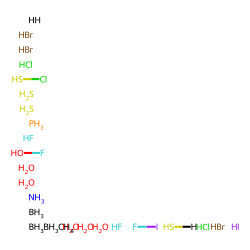

In [177]:
mol

In [178]:
mol = graph_to_molecule((f, e, e_a))

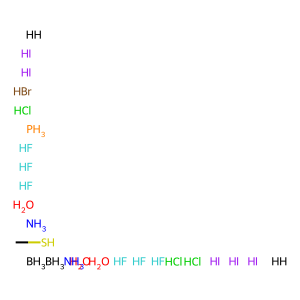

In [81]:
Draw.MolToImage(mol) 

In [28]:
train(g, train_loader=train_loader, valid_loader=val_loader, epochs = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(36741.8481, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(36519.3125, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(36392.1363, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(36207.4476, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(36645.9763, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(36248.6256, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(36136.3319, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(35868.8323, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(35681.4597, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(35597.4732, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(35447.6012, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(35315.7536, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(35089.3264, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(35529.7380, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(35127.6450, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(35020.3048, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(34850.9733, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(34562.3348, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(34609.9812, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(34503.3162, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(34389.1715, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(34137.9943, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(34617.4291, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(34259.7506, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(34108.6289, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33882.3792, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33724.8226, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33839.5712, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33689.2730, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33591.1793, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33369.7447, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33834.6050, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33519.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33355.6680, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33127.1838, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32975.0573, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33115.2819, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32929.6912, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32854.5077, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32647.7212, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(33134.0701, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32724.8791, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32606.8986, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32353.8537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32242.0025, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32386.1630, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32269.1520, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32186.4001, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31942.7720, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32400.4566, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(32055.1687, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31913.0866, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31690.1837, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31556.4089, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31787.0809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31644.9453, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31554.1655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31356.1568, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31804.6636, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31463.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31343.8282, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31092.5178, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30928.4830, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31198.7777, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31069.0506, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30972.2339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30776.0045, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(31221.2044, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30912.2581, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30791.6258, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30553.1134, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30362.4303, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30668.5226, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30533.4860, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30405.8864, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30236.9461, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30679.2883, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30364.1643, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30256.0098, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30013.1955, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29824.9714, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30140.5185, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29993.0001, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29870.2300, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29693.7641, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(30148.3508, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29807.4614, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29730.8521, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29500.0689, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29299.1962, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29688.1295, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29507.4450, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29382.0644, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29227.6020, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29638.1326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29326.3912, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29235.8596, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29001.0898, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28868.8267, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29220.5590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29092.7595, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28933.6148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28793.6702, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(29234.4880, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28900.4610, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28814.6036, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28553.8833, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28417.9854, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28749.7997, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28586.6600, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28469.1770, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28365.6335, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28801.0971, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28452.0316, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28382.8148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28111.6486, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27958.6080, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28328.4849, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28138.4529, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28053.4119, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27929.1626, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28356.3645, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(28035.7819, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27946.9888, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27684.7741, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27531.8772, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27932.9127, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27725.3124, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27651.1401, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27503.7059, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27968.4775, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27630.5218, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27558.3986, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27274.0353, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27104.0943, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27548.4537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27334.1326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27245.7964, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27111.0262, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27557.9976, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27222.1547, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27159.4221, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26880.0588, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26709.1748, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27168.9793, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26945.2751, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26852.2787, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26726.2112, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(27156.8098, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26829.5823, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26778.8599, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26498.2580, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26298.4298, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26781.8387, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26575.5679, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26489.7883, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26366.7463, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26786.8685, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26470.8692, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26424.1368, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26147.2194, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25938.4439, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26434.1373, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26222.7520, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26134.7729, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26027.3010, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26435.7263, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26097.7029, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26055.7715, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25785.6155, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25571.7660, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26069.3793, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25878.6459, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25791.4564, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25689.6388, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(26090.0251, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25750.1447, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25705.9301, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25432.1838, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25214.1396, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25741.3914, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25542.0488, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25456.9449, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25347.2877, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25758.7668, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25418.5198, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25373.0943, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25104.0630, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24889.2803, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25411.1860, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25241.2806, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25148.9899, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25031.1503, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25443.1009, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25119.7781, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25077.3066, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24791.0272, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24573.4030, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25102.8757, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24939.4723, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24834.5251, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24731.2971, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(25141.5326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24816.5160, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24758.5315, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24492.0726, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24270.9225, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24804.7432, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24632.2574, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24542.2498, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24426.0254, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24833.6751, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24511.8010, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24452.4201, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24183.5862, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23965.6666, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24505.3795, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24319.5252, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24239.6282, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24120.5338, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24535.1477, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24203.5372, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24147.7815, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23882.3867, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23661.1357, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24211.5513, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24027.8030, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23966.4288, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23810.9102, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(24249.6305, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23913.6977, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23847.9317, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23599.7601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23372.8188, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23923.4364, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23747.8588, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23676.4060, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23528.1664, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23962.1929, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23622.6404, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23560.5509, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23322.4672, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23096.3405, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23651.5605, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23463.6521, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23393.0953, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23248.7928, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23675.0793, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23353.1018, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23286.6875, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23042.9003, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22830.7033, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23404.8406, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23207.8057, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23134.5983, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22991.1781, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23419.6729, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23098.8029, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23024.9529, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22778.9160, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22570.8677, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23138.6727, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22948.8606, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22881.1207, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22737.4146, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(23163.6105, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22842.9051, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22768.6525, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22523.0368, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22312.3878, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22892.4657, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22699.0601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22630.8338, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22485.8541, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22908.6089, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22594.3405, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22518.9689, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22274.2664, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22062.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22631.4283, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22444.0351, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22385.8490, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22237.5103, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22660.2376, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22339.7196, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22277.1289, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22035.7094, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21820.2721, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22390.6073, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22194.7012, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22156.5351, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22005.9517, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22416.9250, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22101.0537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22042.8789, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21799.1466, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21582.9097, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22156.7720, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21962.1176, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21924.0503, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21775.8596, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(22184.6304, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21869.3032, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21809.6994, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21571.1894, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21351.4694, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21932.9615, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21739.1949, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21684.0911, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21539.8618, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21962.0383, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21651.8728, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21585.4533, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21337.4420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21123.2333, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21701.6899, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21504.5073, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21449.7809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21311.0260, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21732.8805, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21418.2507, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21353.0080, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21113.7739, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20893.2349, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21477.9127, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21280.2028, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21228.6320, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21091.0229, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21509.8569, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21194.1723, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21131.6211, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20892.5684, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20675.7112, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21261.7017, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21067.9877, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21014.3864, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20877.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21294.8666, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20977.9303, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20917.1581, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20678.7972, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20462.4360, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21051.8621, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20853.1252, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20803.1052, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20667.3596, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(21085.4094, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20770.0732, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20708.4062, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20469.1137, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20252.5533, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20844.1844, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20649.5329, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20598.1186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20462.1054, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20878.9017, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20561.8826, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20502.3955, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20264.5832, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20048.3953, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20643.8951, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20445.6404, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20394.3642, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20260.7932, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20682.6105, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20365.5664, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20300.1328, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20062.0727, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19844.5497, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20437.5066, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20238.3257, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20187.2237, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20055.9239, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20474.4214, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20156.0392, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20096.0375, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19855.6782, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19639.1082, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20238.0925, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20038.6779, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19990.6343, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19860.3536, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20275.5955, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19958.7640, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19900.5025, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19661.3553, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19445.4890, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20046.0787, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19846.7142, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19799.4938, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19669.2597, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(20084.5737, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19768.0313, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19710.1114, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19471.1996, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19255.0907, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19857.7814, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19658.4664, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19611.9201, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19482.8091, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19896.4154, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19579.7073, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19522.4809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19284.6504, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19068.6783, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19672.5841, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19473.2417, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19427.4397, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19297.8830, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19712.1473, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19395.0322, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19338.3969, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19101.1617, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18884.9874, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19490.9146, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19291.5736, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19246.1321, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19118.5139, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19530.4898, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19214.7231, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19157.8052, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18920.9009, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18704.7837, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19311.7368, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19112.4726, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19067.9021, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18938.9166, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19352.4796, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19035.2392, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18979.4666, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18743.6451, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18527.3408, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19136.0571, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18936.7692, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18892.3511, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18766.1740, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19176.4097, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18861.5902, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18804.9433, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18569.0624, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18352.8616, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18962.2789, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18763.1571, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18719.7219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18591.3030, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(19004.1136, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18686.8753, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18631.8579, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18397.4240, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18181.0040, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18792.3660, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18593.2324, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18549.8313, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18424.6121, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18833.5168, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18520.0796, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18463.5034, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18228.5130, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18012.2820, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18624.0885, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18425.1924, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18382.8311, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18255.1343, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18667.0970, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18349.7370, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18295.6329, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18062.5883, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17846.0184, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18459.3544, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18260.3547, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18217.9278, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18093.5552, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18501.1382, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18187.9888, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18133.2073, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17898.2195, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17681.9418, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18295.8090, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18097.0789, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18055.5874, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17929.1701, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18339.3061, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18022.5568, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17969.0346, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17736.9050, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17520.3309, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18136.1570, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17937.3219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17895.8609, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17773.2352, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18178.3629, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17866.0193, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17811.5672, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17577.6053, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17361.2112, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17988.2838, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17785.1130, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17745.5812, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17607.8924, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(18024.4597, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17707.6763, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17659.7071, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17430.0070, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17221.4533, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17833.3328, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17631.2194, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17587.8965, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17455.4501, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17869.6751, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17557.5957, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17508.4353, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17275.5238, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17062.5891, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17675.9892, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17475.0466, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17435.4304, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17305.4440, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17723.6851, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17400.9023, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17355.7154, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17127.6670, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16904.7234, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17524.7114, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17321.4728, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17282.9680, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17154.7874, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17576.0594, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17252.2996, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17211.6994, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16981.3029, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16750.8952, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17375.7037, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17171.8353, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17133.9779, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17004.4454, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17428.0869, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17101.0218, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17059.6451, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16834.9229, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16603.4403, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17227.6691, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17025.0473, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16987.5153, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16860.3206, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17279.9018, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16957.2390, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16916.4939, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16687.6372, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16457.5788, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17081.7976, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16879.7375, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16842.7244, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16713.8542, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(17135.2768, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16810.5805, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16770.1194, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16544.4914, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16313.7966, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16940.5050, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16745.7538, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16708.1756, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16574.4861, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16995.1277, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16674.4513, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16636.9294, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16404.1543, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16170.8996, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16805.3967, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16601.8451, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16564.2424, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16438.1704, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16862.9406, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16539.5392, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16499.0575, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16268.6850, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16034.8284, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16672.0144, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16473.8144, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16435.3111, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16305.0886, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16728.5542, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16414.2913, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16351.8556, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16140.8474, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15920.2019, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16530.6484, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16328.0501, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16292.4679, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16166.8355, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16583.5024, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16272.8367, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16205.3505, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15996.2448, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15781.2148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16377.3593, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16184.7776, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16146.1427, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16025.2698, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16438.2300, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16117.6748, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16059.6475, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15843.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15622.8986, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16258.4413, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16062.5440, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16019.0684, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15895.1579, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16316.6924, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16003.3381, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15939.8472, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15724.8345, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15487.3323, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16132.0395, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15932.7473, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15887.7537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15771.7845, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16195.9728, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15860.9102, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15812.4670, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15596.3335, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15355.3403, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15994.1914, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15796.9287, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15756.7537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15629.8655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(16051.7118, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15725.0890, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15687.4816, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15469.8723, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15225.3457, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15858.0308, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15654.8123, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15627.3165, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15493.6952, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15911.5656, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15588.8473, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15551.5977, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15330.6075, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15096.1334, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15720.9148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15528.7026, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15498.2318, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15362.8399, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15790.1172, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15460.9706, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15420.4165, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15201.5333, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14964.3096, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15572.6984, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15370.9782, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15344.6626, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15213.4711, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15630.1621, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15313.7285, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15260.3492, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15051.6711, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14828.8565, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15440.5635, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15241.8023, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15212.7699, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15083.6978, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15485.7957, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15178.2534, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15121.0702, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14912.2928, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14720.7700, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15310.6324, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15120.5625, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15085.7807, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14967.6357, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15358.7856, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15053.4849, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14992.2727, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14785.7276, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14584.0692, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15183.5646, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14993.1700, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14962.0711, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14843.0686, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15235.7113, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14933.6584, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14868.3896, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14662.7837, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14458.7760, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15039.6684, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14871.2742, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14822.2870, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14705.5299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(15096.3886, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14800.2005, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14729.1356, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14524.9377, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14331.6914, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14920.8327, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14743.9228, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14698.2945, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14592.3019, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14975.4966, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14675.5056, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14606.4600, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14403.3591, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14206.2708, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14797.8147, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14621.5952, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14580.1933, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14471.1044, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14856.9968, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14556.4350, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14487.7484, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14285.6901, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14089.0333, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14679.1988, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14502.8906, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14464.7888, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14357.2734, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14740.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14439.8552, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14370.5179, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14169.4377, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13973.5129, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14562.3428, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14386.0837, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14350.4572, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14239.6859, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14624.4892, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14326.0752, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14254.2324, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14054.0918, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13860.0417, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14447.6736, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14271.5445, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14234.8549, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14126.2721, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14510.5920, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14211.1835, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14140.8828, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13941.5788, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13747.8463, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14332.6136, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14156.6821, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14119.2713, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14010.3950, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14398.3008, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14092.7619, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14026.5198, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13828.5897, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13643.1061, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14215.8263, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14041.8347, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13999.1527, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13896.0759, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14292.6716, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13972.2167, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13909.4054, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13719.0084, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13512.1228, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14098.5314, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13913.5406, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13874.2124, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13786.1564, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14162.2979, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13852.9735, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13794.5219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13592.7698, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13389.7271, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13989.8605, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13800.2213, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13758.8050, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13668.1941, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(14055.0948, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13735.7082, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13679.0334, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13480.8695, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13272.6743, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13873.8105, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13689.7157, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13645.9547, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13569.7512, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13938.1943, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13620.0551, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13563.1893, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13369.2049, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13159.8385, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13761.7512, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13571.9653, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13531.7024, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13437.7427, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13822.6011, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13507.4212, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13451.9115, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13261.2439, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13051.9227, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13655.8308, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13466.1495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13426.6718, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13332.5046, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13716.5616, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13401.7895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13346.1970, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13156.4900, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12946.0397, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13551.2829, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13359.8650, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13320.8191, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13226.4192, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13610.2488, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13295.8763, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13240.1377, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13052.3703, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12839.3255, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13450.5633, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13255.7474, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13215.9452, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13122.4419, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13505.4167, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13192.1578, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13137.5696, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12949.7122, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12736.6449, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13344.2545, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13152.5882, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13112.2630, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13019.1568, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13401.3341, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13088.8401, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13035.4937, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12847.6127, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12633.7015, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13239.6768, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13050.2790, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13010.3329, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12917.1397, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13299.0403, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12986.9434, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12932.5899, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12746.9655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12532.6233, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13137.7763, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12949.5601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12917.1037, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12823.7392, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13199.2890, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12885.7889, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12830.9460, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12644.6517, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12435.6753, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13037.6190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12845.8959, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12791.3560, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12714.4979, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(13092.9456, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12789.0144, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12740.8828, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12541.1775, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12338.4571, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12941.2219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12743.6634, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12690.9134, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12616.9050, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12993.3080, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12691.1403, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12648.1271, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12443.2480, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12242.3645, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12849.0699, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12651.9810, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12599.6772, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12524.6156, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12903.0561, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12598.4568, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12548.1777, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12350.7376, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12151.7950, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12748.0568, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12561.9423, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12505.8820, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12427.8458, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12799.8623, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12502.4580, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12448.2704, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12256.3003, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12059.9594, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12650.7978, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12466.7261, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12409.0844, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12331.9806, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12703.6645, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12406.9128, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12351.6325, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12162.1649, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11964.3256, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12553.9683, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12373.0551, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12323.9628, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12238.2465, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12611.0955, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12306.9462, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12251.8617, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12071.3432, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11865.3023, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12459.1092, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12275.9961, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12229.1693, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12144.3718, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12517.3062, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12212.9860, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12157.8101, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11978.6589, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11772.5017, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12365.2418, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12182.1833, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12135.4540, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12051.7217, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12425.0148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12119.9725, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12064.8676, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11886.8458, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11679.5576, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12272.8013, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12090.1685, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12043.6537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11960.6899, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12333.5220, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12028.7870, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11973.6726, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11796.3864, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11589.1401, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12181.1579, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11999.3840, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11952.9780, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11870.0709, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12245.1296, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11937.9947, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11882.6607, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11706.7166, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11499.0486, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12089.3772, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11910.2928, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11862.1741, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11779.5681, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12147.9084, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11847.3834, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11792.0437, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11618.1776, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11409.4469, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11998.5090, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11819.4633, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11772.1390, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11689.9354, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(12055.7168, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11757.2979, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11701.9158, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11531.8946, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11320.1283, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11908.7428, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11728.2396, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11683.3251, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11601.6850, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11965.7029, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11668.6971, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11613.2886, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11444.5326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11232.5533, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11820.0414, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11639.0149, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11595.4471, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11514.4671, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11876.6825, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11580.9165, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11525.4380, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11355.4005, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11145.7573, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11732.4529, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11551.3618, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11508.7963, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11428.5746, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11789.1415, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11494.5441, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11438.9514, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11269.1072, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11060.4388, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11645.9441, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11464.8839, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11423.0153, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11343.6373, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11702.3579, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11408.7631, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11353.0468, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11183.5806, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10975.6143, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11559.2013, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11377.8324, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11337.0635, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11270.2254, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11616.9771, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11325.4356, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11270.6467, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11108.3001, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10897.4145, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11489.3733, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11308.1955, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11267.0683, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11186.2218, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11546.8091, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11254.2586, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11197.4883, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11025.6364, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10826.5246, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11406.0716, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11225.1833, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11184.2367, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11103.3286, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11463.0750, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11171.0973, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11114.0323, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10943.3240, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10743.8323, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11320.6246, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11141.2894, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11100.4960, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11019.6770, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11379.2828, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11087.5201, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11030.4612, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10861.2694, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10661.0852, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11236.8220, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11058.5539, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11017.8974, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10937.2976, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11296.6903, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11004.8615, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10947.9332, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10780.1961, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10579.5810, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11154.2071, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10977.0174, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10936.3108, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10856.0349, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11215.6088, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10923.5836, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10866.5594, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10700.1884, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10499.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11072.6551, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10896.4867, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10855.8725, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10776.1170, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11136.2671, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10843.5032, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10786.2277, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10621.3175, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10420.1986, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11005.1732, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10810.5555, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10782.0230, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10688.9266, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(11027.0527, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10744.4739, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10688.0322, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10541.7761, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10331.1810, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10886.7473, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10707.3106, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10675.2893, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10575.5496, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10920.0042, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10642.1291, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10592.8030, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10464.7672, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10240.5543, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10805.7654, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10633.4979, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10597.2128, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10495.2558, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10839.4632, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10563.5405, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10513.0389, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10386.3281, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10163.3699, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10727.3388, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10550.1570, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10522.7791, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10422.7619, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10760.1670, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10487.0079, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10432.3523, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10304.6436, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10085.0713, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10647.5535, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10473.8149, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10435.8448, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10330.4154, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10678.4596, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10408.3044, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10351.9203, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10224.6948, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10008.0467, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10576.7990, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10388.1830, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10357.2201, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10253.5373, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10598.6834, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10333.8722, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10276.0368, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10154.7094, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9932.1326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size(

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10473.3219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10310.1070, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10281.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10187.0281, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10514.5803, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10243.1902, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10194.9894, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10080.3467, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9843.5583, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size(

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10378.4277, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10233.8958, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10194.9452, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10094.3159, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10425.5175, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10176.6967, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10120.8858, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10012.9165, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9761.6419, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size(

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10324.5761, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10173.6646, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10132.0028, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10035.5385, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10374.6465, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10097.5236, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10062.8618, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9956.5396, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9716.8076, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10227.0233, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10081.5840, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10045.5568, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9928.2628, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10282.1622, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10000.6717, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9966.9760, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9862.0899, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9607.8184, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([10

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10145.4339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10002.0593, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9968.4340, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9852.2190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10195.3989, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9925.9685, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9886.6987, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9787.4064, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9533.2536, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10070.1397, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9926.7476, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9890.8314, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9771.1856, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10118.3082, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9855.5366, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9811.8167, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9704.5498, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9461.3589, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024,

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9995.9911, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9853.7330, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9820.7803, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9701.4706, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(10041.2659, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9791.4187, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9738.9579, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9629.5240, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9386.3775, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9918.2274, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9775.1923, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9744.3364, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9620.8993, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9956.8154, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9701.7619, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9661.6972, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9534.0924, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9310.2156, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9847.5791, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9698.7848, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9670.5363, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9542.8662, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9878.2420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9626.3655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9587.6466, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9456.2504, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9240.9083, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9777.8240, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9623.5293, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9602.9609, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9476.9387, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9806.3508, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9551.2794, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9519.0049, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9383.6349, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9164.3499, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9700.7377, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9551.1126, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9539.1867, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9420.7159, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9737.7323, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9474.7621, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9455.4833, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9320.8437, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9098.8079, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9621.4664, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9477.6624, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9470.4560, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9357.5941, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9660.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9396.9625, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9378.0664, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9244.8283, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9025.1284, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9535.7041, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9397.1658, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9370.9524, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9269.7396, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9579.9040, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9316.7033, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9298.9244, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9163.0110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8941.5613, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9457.8940, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9314.7655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9289.5675, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9178.5428, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9500.1106, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9238.8991, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9231.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9079.4730, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8867.0051, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9382.9782, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9246.7831, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9212.0991, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9103.2275, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9427.5988, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9173.8190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9154.5259, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9007.8904, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8794.6194, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9309.9012, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9174.8264, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9144.3836, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9044.6739, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9357.9160, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9097.5183, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9086.6107, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8947.9970, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8729.1245, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9237.0495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9105.1095, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9071.9964, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8972.9978, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9285.9529, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9025.1876, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9014.8061, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8879.8307, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8659.5452, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9165.5962, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9033.2411, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9005.3236, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8900.1352, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9214.8119, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8955.1979, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8943.5566, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8812.5269, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8590.4142, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9094.3618, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8960.6647, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8930.7150, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8825.5981, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9143.1445, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8885.8793, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8871.9772, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8734.2642, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8521.3625, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9038.2306, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8902.1069, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8874.5861, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8766.5123, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9087.3644, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8833.4929, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8818.8485, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8677.8684, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8466.9859, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8977.1172, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8838.7737, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8813.8741, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8703.7226, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(9024.2845, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8772.0180, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8756.2476, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8614.4239, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8404.5603, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8911.6926, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8774.3113, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8753.1088, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8640.2073, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8959.4429, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8706.2186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8692.2670, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8551.2690, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8342.2132, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8846.7313, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8710.2272, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8686.3041, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8575.5357, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8894.2480, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8642.3545, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8627.7754, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8487.7012, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8279.6192, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8782.3428, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8646.6890, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8620.5227, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8512.5315, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8830.1904, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8578.6623, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8564.5517, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8425.2405, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8218.0107, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8705.7137, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8572.9851, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8544.6098, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8440.8113, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8755.3592, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8504.1382, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8489.7505, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8353.5413, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8147.5958, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8642.0703, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8509.4349, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8481.1252, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8378.4023, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8692.1547, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8441.8984, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8427.6521, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8292.1923, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8087.0241, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8580.9692, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8448.6736, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8420.2985, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8318.2999, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8631.3429, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8382.1224, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8367.9056, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8233.1282, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8028.6790, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8520.6575, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8388.5643, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8360.0666, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8258.6014, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8570.7334, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8322.3840, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8308.1400, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8174.0469, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7970.2677, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8460.1914, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8328.3115, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8299.8495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8199.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8510.2266, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8262.7819, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8248.6401, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8115.3155, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7912.1742, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8400.4640, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8268.8176, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8240.4793, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8140.2128, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8450.4735, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8203.9773, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8189.8526, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8057.3699, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7854.9169, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8341.6832, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8210.3926, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8182.1162, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8082.4349, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8391.8797, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8146.4186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8132.3270, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8000.5643, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7798.7590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8283.5761, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8152.4792, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8124.2133, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8024.9625, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8333.4352, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8088.8643, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8074.6690, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7943.7446, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7742.6173, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8225.3750, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8094.4659, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8066.3484, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7967.6779, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8275.1293, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8031.5232, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8017.4730, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7887.3326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7686.7493, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8168.0512, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8037.3777, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8009.4387, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7911.2612, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8217.7951, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7975.1723, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7960.9783, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7831.8392, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7632.0345, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8111.4332, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7980.9056, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7953.1092, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7855.4295, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8160.8854, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7919.2860, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7905.2773, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7776.8106, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7577.4304, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8056.1201, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7925.9537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7898.4355, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7801.1386, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8105.8685, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7865.4348, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7850.9940, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7723.6741, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7525.2645, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8001.7036, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7871.5702, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7844.0838, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7747.0970, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(8050.6531, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7811.2984, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7797.1428, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7670.1954, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7471.9344, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7946.3952, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7816.1633, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7788.8283, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7692.2838, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7994.8754, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7756.3047, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7741.4884, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7616.0688, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7419.1227, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7891.7124, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7761.3338, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7734.2570, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7638.4011, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7939.7055, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7702.3858, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7688.6217, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7563.1917, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7366.0156, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7837.8587, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7706.9489, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7679.9951, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7584.4675, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7884.9406, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7648.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7632.9014, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7509.7474, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7314.9461, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7785.3597, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7653.4829, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7626.8626, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7532.1541, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7831.1536, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7596.0298, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7583.0026, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7458.6601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7262.5262, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7739.6190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7602.5873, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7575.9757, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7480.8517, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7779.8718, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7544.8532, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7527.7336, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7407.2515, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7216.3712, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7676.4339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7543.1907, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7520.5110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7422.6104, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7725.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7483.2830, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7461.0062, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7346.0890, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7161.8576, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7615.6677, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7486.2584, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7468.5865, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7367.9834, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7667.8198, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7429.4577, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7400.9145, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7283.0834, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7111.9340, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7567.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7438.6235, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7416.4081, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7320.9183, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7621.5295, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7382.7395, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7362.4194, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7248.4953, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7058.6751, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7505.3079, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7383.4462, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7365.7084, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7266.0240, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7561.5514, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7325.4921, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7297.8645, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7181.4619, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7011.8601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7444.2037, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7317.2188, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7313.3647, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7212.3108, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7501.7807, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7259.7246, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7243.8156, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7130.0482, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6973.3879, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7394.2629, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7270.1990, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7264.4511, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7165.7275, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7459.2714, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7214.8297, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7194.7271, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7080.1944, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6912.2816, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7347.4260, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7229.9321, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7214.4461, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7117.6410, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7407.3539, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7172.3632, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7147.4324, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7033.8688, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6864.7831, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7294.1728, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7171.7635, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7165.5072, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7068.2153, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7356.3020, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7116.2024, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7096.4002, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6983.6069, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6817.4533, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7239.1319, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7111.3314, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7115.7646, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7017.1919, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7291.9311, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7057.5350, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7048.9662, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6935.5895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6763.9335, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7189.7136, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7056.2485, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7058.8578, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6960.5811, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7234.3025, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7002.7688, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7003.6482, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6879.3118, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6714.2456, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7150.7633, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7035.4477, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7024.3350, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6927.0043, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7211.5884, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6984.9244, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6955.6288, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6846.5070, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6682.5823, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7099.7343, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6984.2724, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6971.9792, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6878.7317, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7160.4950, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6930.1870, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6906.9299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6797.6905, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6631.4199, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7052.0037, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6936.5739, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6925.6943, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6834.2246, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7113.1597, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6884.3931, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6859.7786, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6752.5052, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6588.4275, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7004.2003, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6888.3631, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6879.2438, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6790.8035, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7066.4885, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6837.1746, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6814.5755, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6707.4655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6542.3308, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6959.3325, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6849.6347, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6842.4745, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6742.3296, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(7023.2540, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6811.4173, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6775.7200, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6667.6023, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6493.0882, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6921.3563, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6796.4021, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6787.3627, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6682.1555, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6973.0239, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6753.5871, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6736.1728, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6623.8895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6455.5348, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6880.8230, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6755.3843, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6740.9336, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6636.0661, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6928.0885, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6702.3881, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6688.7784, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6575.6984, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6401.2746, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6831.7181, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6711.8217, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6693.9495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6590.5376, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6886.4458, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6655.2494, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6646.8377, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6532.5454, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6363.8092, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6788.0464, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6660.0923, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6654.4694, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6548.1931, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6839.9184, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6608.8951, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6599.4159, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6488.5875, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6321.1845, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6737.8836, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6611.6004, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6605.0611, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6496.3428, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6787.0009, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6558.2126, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6556.7731, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6449.4479, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6293.9467, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6692.8920, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6569.8540, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6554.3029, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6446.7098, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6743.1578, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6505.0765, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6511.8994, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6408.5737, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6229.4415, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6645.7624, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6527.5904, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6509.6629, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6397.3089, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6695.2115, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6457.7584, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6468.2512, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6362.4460, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6180.6443, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6602.9809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6486.0654, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6465.3921, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6353.4236, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6648.4508, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6413.9163, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6426.3348, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6321.6519, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6142.3989, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6560.5224, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6444.4733, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6423.3532, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6311.8233, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6605.3351, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6372.2145, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6384.7902, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6280.7666, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6103.7275, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6524.3491, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6400.8672, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6383.0394, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6268.6944, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6560.0021, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6327.9891, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6345.5812, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6236.7637, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6052.1573, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6474.6055, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6364.0249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6341.8452, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6226.9762, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6516.9979, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6285.1131, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6296.1057, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6194.9535, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6010.6400, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6428.1097, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6314.4596, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6301.4309, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6186.4899, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6477.7252, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6243.7259, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6253.3542, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6151.7346, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5971.9417, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6390.1800, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6276.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6260.6394, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6147.3655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6435.6979, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6204.9742, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6215.1110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6115.3257, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5934.0845, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6348.3038, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6235.4338, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6221.3421, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6108.1784, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6403.9815, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6166.1355, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6178.1424, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6080.5739, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5899.2177, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6313.1891, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6204.1532, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6183.9852, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6077.2344, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6361.7589, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6136.2495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6146.0720, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6048.6527, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5870.5869, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6273.5755, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6164.5613, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6144.7290, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6037.9695, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6320.9365, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6096.8613, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6106.4199, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6009.4770, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5833.6758, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6234.5909, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6124.9749, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6105.8285, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5998.9610, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6280.3472, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6057.7719, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6067.2922, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5970.8851, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5803.0331, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6203.5970, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6084.8577, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6068.3421, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5958.8522, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6237.8556, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6016.8433, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6028.4632, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5930.7721, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5754.0132, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6159.2116, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6047.4674, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6030.9363, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5920.0693, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6196.9538, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5976.8530, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5986.3983, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5895.3650, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5715.3459, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6113.3031, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6005.2968, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5996.0642, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5882.9308, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6158.5204, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5938.8466, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5946.8015, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5853.7157, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5680.0847, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6073.4868, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5967.0390, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5957.6687, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5846.6006, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6121.3985, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5901.9603, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5909.1087, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5816.6314, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5647.0091, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6033.5963, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5928.6316, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5918.0177, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5810.7943, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6083.3174, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5864.9916, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5870.9337, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5778.9454, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5608.3936, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5993.4071, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5890.2148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5881.3213, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5776.4822, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6042.0462, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5828.4855, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5833.2828, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5742.1216, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5571.5511, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5958.0120, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5855.2958, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5845.6727, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5740.5786, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(6007.1127, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5793.7732, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5798.6882, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5708.8763, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5539.5519, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5919.4205, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5818.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5812.4203, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5711.2950, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5967.8127, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5758.1398, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5761.8685, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5672.8344, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5503.8946, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5882.4498, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5782.1472, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5778.1880, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5672.5154, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5930.6372, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5723.3033, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5725.9359, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5637.6492, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5469.3933, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5844.6379, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5745.7121, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5738.4891, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5635.2401, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5892.9977, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5689.0881, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5689.9721, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5602.5584, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5435.5431, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5807.7151, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5710.0398, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5699.1759, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5600.2425, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5856.2349, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5656.5124, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5654.6484, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5568.1796, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5402.8262, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5771.9378, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5675.2635, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5663.2342, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5566.3775, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5820.4714, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5623.4276, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5620.1048, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5534.5606, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5371.9757, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5736.0887, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5640.5572, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5627.2020, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5532.8924, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5784.6438, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5586.1219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5585.5966, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5501.0260, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5338.3964, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5700.4158, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5606.1387, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5591.7134, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5500.2601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5749.1966, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5551.1971, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5551.5106, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5467.9195, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5303.7833, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5665.5348, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5572.3703, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5557.0371, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5469.3156, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5714.1586, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5517.0243, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5517.6867, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5435.0312, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5270.4262, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5631.2255, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5539.1580, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5523.4369, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5439.9453, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5679.9911, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5483.9789, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5484.6568, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5403.0051, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5238.5198, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5596.7508, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5506.0437, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5489.3268, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5402.3699, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5645.4938, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5450.6261, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5451.4776, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5370.8222, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5206.3852, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5563.2166, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5473.7706, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5456.5204, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5369.9000, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5612.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5418.4489, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5419.2563, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5339.6354, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5175.5692, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5529.9849, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5441.9818, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5423.9874, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5337.9977, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5578.8213, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5386.5233, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5387.2541, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5308.6646, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5144.9683, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5497.1694, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5410.9585, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5391.9546, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5306.7745, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5546.0778, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5355.1199, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5355.7960, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5278.2328, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5114.8762, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5464.8595, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5381.4722, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5360.3287, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5276.0807, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5513.5850, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5323.9854, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5324.5437, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5248.0061, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5085.0239, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5432.5899, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5352.0376, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5328.8896, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5245.7355, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5481.1961, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5293.0072, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5293.4230, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5217.9389, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5055.3384, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5400.1472, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5316.5440, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5297.3358, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5216.1479, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5448.7993, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5262.1494, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5262.4799, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5188.0731, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5025.8608, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5368.5872, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5284.9844, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5266.8336, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5189.0853, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5417.3369, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5232.3158, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5232.5069, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5159.2131, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4997.4493, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5337.7957, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5254.5729, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5236.9651, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5158.8108, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5386.2252, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5202.7784, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5202.6739, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5130.4414, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4969.0976, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5306.5368, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5223.7171, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5206.7069, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5126.6916, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5354.9238, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5173.1090, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5172.7320, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5101.6465, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4940.8016, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5275.8111, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5193.5016, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5176.9784, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5096.5366, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5324.2231, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5143.9502, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5143.2634, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5073.3287, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4913.0267, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5245.9639, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5164.2534, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5148.1780, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5067.6323, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5294.6492, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5115.8010, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5114.8419, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5046.0585, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4886.3120, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5217.0258, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5135.6963, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5119.8563, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5039.2492, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5265.4342, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5087.7237, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5086.4097, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5018.7163, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4859.5107, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5187.6002, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5106.6481, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5091.1684, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5010.8081, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5236.1545, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5059.5045, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5057.8804, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4991.3515, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4832.7738, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5158.5563, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5077.9911, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5062.8644, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4982.8345, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5207.2873, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5031.6702, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5029.7121, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4964.3473, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4806.4453, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5129.6852, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5049.4998, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5034.7191, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4954.9713, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5178.5046, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5003.9269, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5001.6366, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4937.3990, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4780.1496, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5101.3734, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5021.6535, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5007.2770, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4927.8730, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5150.5655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4977.0062, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4974.4162, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4911.3217, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4754.8161, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5073.8176, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4994.5591, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4980.4387, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4901.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5122.7063, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4950.2354, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4947.4533, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4885.4471, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4729.5648, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5017.3756, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4960.0037, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4935.6481, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4864.9515, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5064.0156, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4911.6221, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4912.5544, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4844.9122, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4703.2688, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4983.6531, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4934.8772, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4896.0439, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4829.1193, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(5029.8816, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4872.5170, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4874.8989, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4820.3813, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4668.0746, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4959.1716, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4911.1622, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4867.5666, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4799.1884, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4993.6384, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4845.9155, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4843.6657, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4794.3630, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4644.5020, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4923.5462, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4881.2453, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4843.0193, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4771.7389, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4964.6302, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4817.6574, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4818.0894, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4764.5247, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4613.9196, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4895.6139, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4852.0051, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4822.1299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4746.8628, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4936.7489, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4791.5209, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4792.2457, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4738.1327, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4586.0098, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4865.3103, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4820.8753, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4800.1329, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4720.6592, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4907.5989, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4769.9874, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4765.1047, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4711.4883, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4559.6798, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4831.9875, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4786.9614, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4767.3354, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4693.7565, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4874.3704, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4728.6032, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4738.2576, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4683.7151, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4526.4798, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4803.9998, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4760.1011, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4737.6339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4667.4518, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4847.3006, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4702.6102, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4714.4202, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4660.4303, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4501.8653, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4776.4196, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4733.4082, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4708.9575, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4643.9842, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4819.2648, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4675.1922, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4683.7850, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4639.9133, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4475.1705, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4748.1707, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4707.1075, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4680.4227, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4612.7793, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4790.9250, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4647.5495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4655.5391, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4609.7388, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4448.6054, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4720.9927, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4686.2324, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4653.5372, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4584.8699, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4763.3570, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4620.8703, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4628.7381, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4586.2273, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4423.1303, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4695.4231, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4658.8933, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4628.8163, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4559.5640, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4737.2958, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4595.8737, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4603.5934, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4561.9420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4399.2894, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4670.4206, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4629.6839, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4606.4848, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4533.5982, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4710.5715, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4570.1536, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4577.7927, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4534.0949, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4374.7491, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4641.8299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4598.3621, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4574.2553, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4506.7156, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4683.1765, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4543.5707, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4551.3441, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4506.6439, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4349.0811, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4614.4402, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4571.7043, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4548.0458, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4482.0483, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4657.4175, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4518.9638, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4526.6852, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4482.5257, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4325.8438, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4588.6203, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4546.3623, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4523.1461, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4458.2150, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4632.3298, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4495.0624, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4502.6480, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4459.2190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4303.2783, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4563.0211, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4521.1843, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4498.3974, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4434.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4607.3432, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4471.2473, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4478.7080, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4435.9973, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4280.7709, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4538.1110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4496.7603, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4474.3597, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4411.3587, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4582.9282, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4448.0282, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4455.3457, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4413.4420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4258.8759, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4507.6248, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4465.8666, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4444.7226, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4383.5341, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4552.9088, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4419.2083, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4426.1334, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4385.5941, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4232.0511, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4482.0294, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4440.8919, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4420.3320, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4360.2395, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4528.2830, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4395.8935, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4402.7107, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4363.1699, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4210.3440, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4458.2788, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4417.6958, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4397.4581, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4338.1365, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4504.8602, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4373.6812, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4380.3121, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4341.6700, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4189.4425, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4434.9210, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4394.9006, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4374.9691, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4316.3832, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4481.7755, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4351.8036, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4358.2372, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4320.5042, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4168.8571, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4411.8791, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4372.4279, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4352.8008, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4294.9299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4458.9850, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4330.2202, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4336.4426, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4299.6326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4148.5546, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4389.1439, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4350.2664, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4330.9326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4273.7595, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4436.4750, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4308.9137, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4314.9218, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4279.0414, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4128.5278, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4366.7011, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4328.4022, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4309.3555, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4252.8706, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4414.2441, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4287.8851, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4293.6662, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4258.7224, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4108.7658, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4344.5431, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4306.8294, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4288.0609, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4232.2477, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4392.2801, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4267.1232, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4272.6751, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4238.6706, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4089.2656, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4322.6687, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4285.5371, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4267.0373, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4211.8868, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4370.5846, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4246.6225, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4251.9406, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4218.8778, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4070.0197, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4301.0674, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4264.5243, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4246.2773, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4191.7801, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4349.1469, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4226.3765, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4231.4594, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4199.3398, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4051.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4279.7305, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4243.7782, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4225.7764, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4171.9229, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4327.9669, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4206.3826, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4211.2286, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4180.0506, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4032.2726, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4258.6488, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4223.2969, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4205.5372, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4152.3124, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4307.0386, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4186.6320, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4191.2479, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4161.0119, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4013.7673, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4237.8226, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4203.0655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4185.5475, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4132.9383, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4286.3542, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4167.1180, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4171.5153, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4142.2210, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3995.5013, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4217.2371, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4183.0884, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4165.8108, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4113.7986, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4265.9101, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4147.8470, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4152.0289, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4123.6749, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3977.4774, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4196.8888, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4163.3501, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4146.3266, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4094.8926, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4245.7024, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4128.7895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4132.7919, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4105.3694, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3959.6886, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4176.7720, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4143.8495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4127.0869, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4076.2010, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4225.7269, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4109.9662, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4113.8051, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4087.3051, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3942.1399, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4156.8844, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4124.5848, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4108.0948, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4057.7290, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4205.9788, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4091.3531, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4095.0708, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4069.4826, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3924.8230, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4137.2310, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4105.5555, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4089.3414, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4039.4631, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4186.4562, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4072.9557, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4076.5987, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4051.9008, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3907.7443, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4117.8179, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4086.7661, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4070.8272, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4021.4033, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4167.1628, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4054.7815, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4058.3884, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4034.5667, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3890.8985, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4098.6798, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4068.2461, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4052.5780, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4003.5756, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4148.1328, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4036.8549, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4040.4581, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4017.5099, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3874.3086, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4080.0147, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4050.1953, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4034.7799, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3986.1493, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4129.5543, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4019.3710, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4022.9412, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4000.9063, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3858.1395, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4061.3583, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4032.1399, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4016.9587, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3968.7249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4110.9702, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4001.8641, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4005.3243, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3984.2964, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3841.9542, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4043.0094, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4014.3845, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3999.4228, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3951.5766, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4092.6984, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3984.6663, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3987.9672, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3967.9889, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3826.0528, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4024.8817, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3996.8460, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3982.0917, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3934.6306, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4074.6408, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3967.6674, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3970.9128, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3951.8980, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3810.3263, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4006.9564, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3979.5215, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3964.9873, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3917.8541, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4056.8011, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3950.8502, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3954.2549, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3936.1136, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3794.8124, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3989.3110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3962.4163, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3948.0239, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3901.4502, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4039.2355, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3934.3323, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3936.1408, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3920.2743, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3779.8200, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3988.2745, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3961.7441, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3938.2422, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3911.7987, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4030.6850, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3929.1734, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3921.0937, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3916.6861, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3769.2675, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3985.3848, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3950.0117, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3933.0058, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3905.3281, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(4020.6166, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3922.3827, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3906.1047, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3906.5409, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3760.1309, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3966.6420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3940.4399, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3911.5382, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3876.8243, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3998.8987, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3898.8170, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3887.8550, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3886.6190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3741.2129, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3925.5843, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3898.2441, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3882.9420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3844.3277, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3972.0363, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3872.7819, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3871.2460, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3856.6938, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3716.4693, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3906.9048, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3880.9278, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3866.6356, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3827.7908, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3955.3072, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3857.2111, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3855.5736, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3842.1913, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3702.2367, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3890.4131, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3865.1624, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3851.0937, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3813.2871, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3939.1446, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3842.5241, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3841.1186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3828.3682, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3688.2810, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3872.6284, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3848.2320, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3835.8326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3793.2340, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3921.7113, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3823.9244, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3822.3426, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3811.0933, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3675.2208, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3850.1908, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3831.4175, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3815.0646, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3771.4496, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3903.4780, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3806.1429, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3801.6167, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3793.6241, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3658.1472, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3832.2519, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3810.0514, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3797.7107, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3753.7106, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3884.1492, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3790.4462, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3785.5318, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3774.9017, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3637.2443, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3813.4800, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3788.5642, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3780.4997, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3735.3002, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3865.2069, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3775.0322, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3765.8128, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3755.0714, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3618.7583, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3800.1611, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3777.9145, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3766.7293, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3723.4546, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3852.3686, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3760.6826, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3755.1551, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3745.6252, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3609.2865, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3785.2803, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3763.9205, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3752.6881, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3710.3815, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3838.6450, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3747.2152, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3741.0475, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3736.9223, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3599.9712, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3770.8557, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3750.5446, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3738.0910, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3696.2915, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3823.0758, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3732.6523, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3726.1988, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3719.8110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3584.3133, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3752.6168, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3730.3515, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3721.9805, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3679.3986, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3805.0694, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3717.6705, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3710.1156, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3701.0900, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3566.6963, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3735.6518, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3713.1185, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3707.5217, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3664.1748, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3788.4110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3703.3503, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3691.6487, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3685.2343, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3551.5515, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3718.4482, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3695.6705, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3698.2334, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3649.3322, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3772.0244, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3689.7772, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3674.9013, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3670.2796, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3537.4496, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3702.5600, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3680.4740, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3690.2004, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3631.1016, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3759.4188, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3680.3433, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3660.1407, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3665.9713, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3532.0673, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3695.9676, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3684.3276, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3657.7655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3618.2354, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3757.7731, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3680.2203, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3649.7692, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3681.2241, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3532.5949, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3673.8561, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3658.5813, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3641.8662, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3598.0445, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3732.9867, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3656.3472, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3627.5105, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3643.7065, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3503.1186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3664.3426, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3654.3087, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3625.9670, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3589.1973, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3731.7560, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3656.9441, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3618.7170, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3652.6348, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3500.1094, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3654.3748, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3639.0594, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3613.1328, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3577.7790, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3725.6682, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3644.8172, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3605.5807, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3637.5274, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3483.1941, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3639.7209, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3624.7085, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3599.4144, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3563.9566, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3708.3847, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3638.0445, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3591.8401, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3631.1941, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3471.9798, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3628.8032, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3614.8963, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3589.5410, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3554.4193, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3695.9566, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3619.4763, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3581.5596, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3619.8196, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3463.5409, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3613.7205, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3599.8727, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3574.3400, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3540.0688, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3682.8293, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3606.3603, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3566.6179, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3603.5925, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3447.8725, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3598.3492, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3584.5323, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3558.6287, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3525.2960, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3666.4191, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3591.9097, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3551.4703, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3588.7854, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3432.2374, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3582.8647, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3568.9391, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3542.7249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3510.0731, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3648.4963, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3574.8833, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3535.9446, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3574.6287, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3415.8493, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3567.6005, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3553.8377, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3527.4977, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3495.5371, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3632.9115, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3561.8138, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3521.6490, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3563.6916, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3401.9235, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3553.2894, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3539.6299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3513.0930, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3481.4216, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3618.0775, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3543.9200, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3507.4077, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3545.4498, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3387.5763, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3535.1523, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3521.6780, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3496.2157, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3464.8664, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3599.7875, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3524.8849, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3490.4220, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3528.2319, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3371.5167, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3519.9467, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3506.7339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3481.9195, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3450.7162, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3584.7072, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3508.7829, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3476.2068, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3514.0215, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3357.5727, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3505.4210, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3492.4894, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3467.9308, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3437.0875, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3570.5023, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3494.0226, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3462.4927, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3501.6697, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3344.1540, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3491.1909, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3478.5227, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3454.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3423.8390, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3556.4914, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3479.4271, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3448.9241, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3489.4185, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3330.7932, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3476.5946, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3463.9373, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3448.5189, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3418.6764, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3535.1501, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3472.8160, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3429.4610, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3463.7542, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3315.7661, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3440.4339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3431.2790, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3394.0491, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3380.5457, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3492.6107, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3421.3079, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3402.2381, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3425.3113, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3287.3358, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3423.4255, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3413.8940, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3374.2776, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3358.6901, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3474.2718, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3404.2807, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3387.7025, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3406.8860, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3271.8834, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3408.6096, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3398.1540, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3358.9313, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3342.9031, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3458.3363, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3389.0816, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3375.5550, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3391.6407, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3259.2602, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3394.2319, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3383.4004, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3344.2387, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3327.8150, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3442.8255, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3374.4493, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3360.7552, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3377.0441, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3245.1420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3379.5157, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3368.1558, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3328.9250, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3311.5575, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3426.3955, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3359.5610, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3343.1288, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3362.7101, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3227.3429, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3366.1913, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3354.4904, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3315.3299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3297.0590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3411.3294, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3346.1187, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3328.3909, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3352.5193, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3212.8738, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3354.1824, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3341.8283, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3302.9874, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3283.6716, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3397.2577, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3333.7771, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3314.8710, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3337.0301, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3199.6594, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3337.9371, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3330.5383, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3288.3212, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3268.7351, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3381.7601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3318.8108, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3299.7820, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3318.7064, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3184.5484, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3321.8641, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3312.5885, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3271.8213, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3254.6725, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3367.1533, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3302.9808, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3285.8450, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3304.0047, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3170.9902, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3307.7194, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3298.4261, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3257.4044, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3241.1950, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3352.9942, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3288.4372, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3272.1343, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3289.6342, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3157.4468, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3292.5186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3283.7133, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3242.1590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3227.0217, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3338.3793, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3273.6653, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3258.1616, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3275.0571, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3143.7466, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3278.6915, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3270.5497, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3228.4809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3213.9809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3324.8046, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3260.3412, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3245.1645, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3261.9018, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3131.1930, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3264.8162, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3257.8241, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3214.6219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3200.6754, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3310.9794, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3246.6926, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3231.8591, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3248.2678, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3118.1709, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3250.8233, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3247.2580, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3200.7574, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3187.3120, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3297.1535, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3233.1129, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3218.6046, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3234.7659, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3105.2416, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3237.2891, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3231.6045, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3187.3215, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3174.2342, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3283.5831, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3219.8013, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3205.5038, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3221.4242, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3092.4163, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3223.7385, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3216.2198, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3173.9297, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3161.2249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3270.1339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3206.6816, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3192.5725, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3208.3339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3079.8356, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3210.5492, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3202.2523, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3160.9330, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3148.5451, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3257.0164, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3193.9425, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3179.9279, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3195.6135, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3067.5638, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3197.5004, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3188.6508, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3148.0427, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3135.9219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3243.9493, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3181.2267, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3167.2979, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3182.8742, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3055.2608, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3184.5160, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3175.2715, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3135.2718, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3123.4181, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3231.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3168.7625, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3154.8462, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3170.3753, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3043.1812, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3171.8108, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3162.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3122.8074, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3111.1835, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3218.3835, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3156.4301, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3142.5945, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3158.1160, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3031.3040, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3159.2837, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3149.5863, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3110.4872, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3099.0517, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3205.9421, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3144.5917, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3130.5039, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3146.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3019.5888, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3146.8997, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3137.0600, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3098.4586, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3087.2619, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3193.4572, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3131.9578, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3118.5052, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3134.0932, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3007.9778, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3134.7813, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3124.8580, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3086.4703, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3075.4504, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3181.4002, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3120.5554, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3106.8448, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3122.4491, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2996.6570, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3122.5762, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3112.5905, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3074.3396, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3063.5426, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3169.6834, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3117.0487, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3098.5971, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3115.4339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2987.8083, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3120.8882, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3080.4396, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3045.8600, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3033.5534, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3127.8186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3077.7929, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3080.3391, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3103.4985, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2976.7962, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3107.5994, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3067.3904, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3040.9186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3021.9943, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3116.5134, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3063.7914, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3065.2986, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3094.4102, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2960.8457, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3090.7145, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3062.0227, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3021.7788, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3012.8761, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3106.0681, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3051.6600, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3054.6160, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3079.4710, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2950.7661, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3079.1786, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3042.3171, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3009.2551, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2998.2740, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3090.6963, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3048.4203, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3043.0730, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3068.1057, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2939.0714, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3067.0604, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3028.3277, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2993.3256, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2985.6334, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3077.2851, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3027.6990, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3030.2283, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3053.3351, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2927.6971, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3056.2639, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3015.6755, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2979.8181, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2973.8279, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3064.9373, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3014.3799, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3018.7454, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3041.4447, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2921.8984, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3048.7777, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3000.6021, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2962.5065, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2961.8607, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3050.9887, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2994.0954, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3004.5673, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3024.1147, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2897.3147, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3035.5005, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2987.9885, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2949.3051, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2953.8590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3035.9080, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2979.6125, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2991.7787, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3010.8823, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2884.8985, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3018.8003, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2975.3688, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2936.3247, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2939.9674, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3022.0209, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2965.7010, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2979.3527, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2997.8815, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2872.4128, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3006.0448, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2963.4253, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2924.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2927.8086, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(3009.2299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2953.0087, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2967.8377, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2985.9152, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2860.8691, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2996.7864, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2951.7698, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2912.2766, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2917.5660, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2996.9096, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2940.8543, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2956.6636, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2974.4855, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2849.7448, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2986.5987, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2940.5253, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2900.9033, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2908.7199, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2984.7713, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2928.5906, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2945.5748, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2962.6568, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2838.1789, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2965.9376, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2928.8033, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2888.3592, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2890.3351, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2971.7570, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2915.6569, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2934.7507, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2950.9744, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2826.7616, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2949.6660, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2917.6286, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2874.7895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2874.0748, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2957.1486, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2900.6461, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2926.1033, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2938.1541, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2813.9029, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2936.8688, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2907.9529, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2863.0471, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2861.8826, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2945.0396, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2888.6753, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2913.0160, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2927.3275, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2803.0225, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2925.2513, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2900.8889, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2851.9254, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2850.6378, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2933.6152, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2877.4022, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2901.8759, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2916.5844, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2792.4911, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2916.8995, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2885.3956, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2843.2802, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2843.4749, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2925.2648, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2869.6788, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2895.7802, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2907.6101, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2784.0548, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2908.8402, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2874.7723, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2834.1880, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2835.5397, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2916.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2860.7488, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2883.0634, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2897.7042, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2774.6506, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2897.0964, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2864.2294, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2823.1760, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2824.1060, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2904.5570, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2849.3693, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2873.9029, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2887.3945, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2764.0554, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2886.1835, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2853.8643, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2812.7139, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2813.6980, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2893.8389, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2838.8157, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2864.7882, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2876.5571, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2753.9556, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2873.5955, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2844.1734, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2801.0911, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2801.1693, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2881.5860, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2826.5301, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2851.7802, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2866.4337, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2742.8828, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2862.1617, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2837.1369, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2790.3196, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2790.1634, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2870.4813, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2815.4635, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2840.6207, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2855.1464, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2732.5590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2851.4272, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2828.5444, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2779.6397, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2779.2126, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2859.2390, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2804.2978, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2829.5522, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2846.1770, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2722.1091, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2839.8461, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2811.1977, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2768.4942, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2767.6426, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2847.7295, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2792.7395, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2819.1895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2834.7139, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2711.5911, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2832.5635, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2803.8948, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2760.6724, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2761.6307, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2840.4182, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2786.3764, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2811.8379, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2827.6241, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2704.1059, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2823.3859, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2793.9355, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2750.8200, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2752.0471, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2830.4569, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2776.5804, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2801.9505, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2814.6089, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2694.3719, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2814.9454, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2787.0023, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2745.7490, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2752.1876, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2825.9743, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2770.9347, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2796.9788, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2808.3120, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2688.4041, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2802.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2774.4017, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2730.5882, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2732.3075, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2810.0835, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2756.7533, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2781.7752, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2798.0186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2675.4040, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2792.1386, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2764.8184, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2721.3416, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2723.1283, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2800.3261, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2747.0675, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2772.1048, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2786.9391, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2665.8854, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2801.1198, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2768.2317, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2724.9783, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2737.5119, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2808.5729, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2754.7302, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2780.8014, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2781.5389, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2672.3316, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2792.5305, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2770.9815, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2727.5673, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2744.7973, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2815.8310, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2760.0219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2787.3724, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2775.4719, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2671.1364, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2785.4280, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2759.1514, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2717.5235, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2728.6778, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2801.6529, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2752.7141, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2786.0636, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2761.9258, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2655.8426, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2753.2242, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2726.3047, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2687.0970, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2687.8293, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2762.3658, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2709.1145, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2734.1436, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2752.6813, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2629.4769, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2743.1984, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2716.6947, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2675.4786, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2677.6058, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2752.3143, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2699.4477, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2724.4774, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2742.9405, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2620.3042, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2733.7200, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2707.3924, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2666.1358, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2668.4040, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2742.7477, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2690.0600, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2715.0601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2733.7220, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2611.1291, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2724.1986, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2698.3116, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2656.8284, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2659.2417, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2733.2418, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2680.7246, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2705.7236, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2724.1106, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2602.0496, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2714.7628, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2689.0183, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2647.5538, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2650.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2723.7827, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2671.4507, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2696.4456, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2714.8251, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2593.0116, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2705.3583, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2679.8915, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2638.3658, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2641.0755, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2714.3809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2662.2225, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2687.2194, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2705.4795, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2584.0217, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2696.0186, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2670.6577, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2629.1943, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2632.0526, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2705.0256, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2653.0367, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2678.0333, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2696.2758, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2575.0673, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2686.7293, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2661.4903, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2620.1121, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2623.1004, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2695.7369, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2643.9083, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2668.9039, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2687.0292, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2566.1608, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2677.4807, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2652.3119, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2611.0423, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2614.1690, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2686.4703, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2634.8114, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2659.8067, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2677.9542, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2557.2873, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2668.2738, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2643.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2602.0446, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2605.2897, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2677.2487, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2625.7520, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2650.7558, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2668.9315, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2548.4630, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2659.1102, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2634.0643, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2593.0739, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2596.4421, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2668.0729, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2616.7346, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2641.7444, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2659.9559, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2539.6691, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2650.0116, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2625.0069, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2584.1640, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2587.6576, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2658.9642, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2607.7802, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2632.7906, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2650.8857, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2530.9248, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2640.9694, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2615.9975, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2575.3033, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2578.9219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2649.9201, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2598.8780, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2623.8847, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2641.8014, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2522.2183, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2631.9490, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2607.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2566.4801, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2570.2172, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2640.8909, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2589.9993, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2615.0054, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2632.9351, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2513.5482, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2622.9380, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2598.0640, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2557.6830, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2561.5177, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2631.8498, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2581.1201, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2606.1390, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2624.3604, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2504.9134, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2613.9729, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2589.1493, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2548.9255, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2552.8597, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2622.8542, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2572.2853, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2597.3207, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2615.7814, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2496.3164, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2605.0867, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2580.3022, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2540.2280, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2544.2745, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2613.9585, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2563.5350, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2588.5711, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2606.8485, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2487.7634, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2596.3507, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2571.5652, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2531.6232, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2535.8163, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2605.2632, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2554.9327, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2579.9448, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2597.2854, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2479.2626, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2587.6113, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2562.8517, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2523.0423, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2527.3683, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2596.5531, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2546.3299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2571.3136, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2588.2734, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2470.7953, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2578.6358, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2553.9952, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2514.3802, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2518.7280, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2587.4703, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2537.4712, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2562.5069, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2581.2325, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2462.3170, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2569.7883, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2545.2327, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2505.7887, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2510.1837, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2578.5397, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2528.7366, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2553.8190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2573.7250, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2453.9040, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2561.0528, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2536.5475, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2497.2521, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2501.7184, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2569.7334, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2520.1094, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2545.2387, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2565.1524, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2445.5442, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2552.6342, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2528.0840, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2488.8877, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2493.5458, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2561.4170, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2511.8355, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2536.9283, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2553.9647, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2437.2419, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2536.1504, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2512.1870, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2479.4297, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2478.3358, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2540.7909, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2492.7590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2528.3086, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2523.4662, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2421.9734, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2523.3764, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2497.2514, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2468.4000, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2467.7475, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2527.2408, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2478.7272, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2514.7533, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2503.6977, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2404.8806, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2513.5800, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2484.7551, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2459.5677, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2459.1560, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2516.4926, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2468.2523, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2507.2579, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2491.1234, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2394.5398, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2505.2388, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2476.9787, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2451.2237, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2450.9858, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2508.5884, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2460.4182, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2498.4514, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2483.9676, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2386.9563, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2496.5307, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2467.6087, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2443.1257, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2442.8166, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2499.4545, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2451.4402, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2491.1224, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2474.2307, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2378.1687, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2488.1536, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2459.4391, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2434.8615, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2434.6895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2491.2387, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2443.3068, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2482.6680, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2466.3291, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2370.2392, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2479.7190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2450.8890, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2426.7565, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2426.6023, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2482.7102, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2434.8879, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2474.9350, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2457.7470, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2362.0324, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2471.3998, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2442.6833, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2418.6110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2418.5471, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2474.4455, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2426.7079, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2466.7729, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2449.6220, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2354.0360, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2463.0848, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2434.3701, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2410.5476, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2410.5321, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2466.1171, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2418.4729, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2458.8983, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2441.3477, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2345.9931, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2454.8352, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2426.1976, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2402.4989, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2402.5549, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2457.8957, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2410.3369, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2450.8617, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2433.2299, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2338.0340, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2446.6078, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2418.0002, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2394.5045, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2394.6105, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2449.6661, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2402.1956, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2442.9809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2425.0775, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2330.0795, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2438.4318, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2409.8818, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2386.5402, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2386.7020, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2441.5091, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2394.1217, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2435.0249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2417.0115, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2322.1792, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2430.2879, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2401.7736, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2378.6203, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2378.8295, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2433.3675, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2386.0586, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2427.1571, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2408.9485, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2314.2975, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2422.1797, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2393.7204, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2370.7317, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2370.9886, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2425.2741, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2378.0448, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2419.2548, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2400.9413, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2306.4588, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2414.1091, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2385.6886, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2362.8882, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2363.1822, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2417.2092, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2370.0600, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2411.4041, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2392.9579, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2298.6476, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2406.0762, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2377.7044, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2355.0744, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2355.4079, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2409.1835, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2362.1136, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2403.5388, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2385.0179, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2290.8724, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2398.0770, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2369.7484, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2347.3041, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2347.6695, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2401.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2354.2006, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2395.7055, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2377.1029, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2283.1255, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2390.1126, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2361.8321, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2339.5654, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2339.9600, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2393.2417, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2346.3221, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2387.8770, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2369.2286, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2275.4145, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2382.1853, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2353.9461, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2331.8609, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2332.2895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2385.3229, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2338.4761, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2380.0777, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2361.3822, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2267.7350, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2374.2904, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2346.1028, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2324.1939, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2324.6477, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2377.4366, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2330.6632, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2372.2969, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2353.5742, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2260.0861, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2366.4329, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2338.2839, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2316.5601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2317.0393, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2369.5848, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2322.8868, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2364.5443, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2345.7953, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2252.4668, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2358.6078, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2330.5031, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2308.9595, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2309.4653, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2361.7689, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2315.1398, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2356.8173, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2338.0502, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2244.8861, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2350.8164, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2322.7578, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2301.3930, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2301.9223, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2353.9848, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2307.4266, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2349.1190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2330.3374, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2237.3302, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2343.0606, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2315.0418, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2293.8605, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2294.4094, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2346.2355, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2299.7497, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2341.4522, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2322.6582, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2229.8079, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2335.3351, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2307.3577, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2286.3614, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2286.9340, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2338.5200, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2292.1016, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2333.8151, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2315.0095, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2222.3163, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2327.6454, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2299.7093, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2278.8927, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2279.4870, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2330.8339, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2284.4872, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2326.2093, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2307.3927, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2214.8585, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2319.9872, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2292.0948, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2271.4578, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2272.0710, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2323.1813, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2276.9043, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2318.6319, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2299.8079, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2207.4308, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2312.3657, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2284.5059, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2264.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2264.6873, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2315.5655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2269.3562, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2311.0855, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2292.2582, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2200.0319, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2304.7737, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2276.9536, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2256.6817, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2257.3360, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2307.9785, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2261.8384, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2303.5730, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2284.7375, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2192.6655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2297.2143, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2269.4352, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2249.3420, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2250.0157, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2300.4268, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2254.3540, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2296.0874, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2277.2467, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2185.3295, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2289.6888, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2261.9438, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2242.0324, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2242.7267, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2292.9050, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2246.9032, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2288.6364, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2269.7895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2178.0243, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2282.1959, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2254.4848, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2234.7548, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2235.4672, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2285.4159, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2239.4820, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2281.2163, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2262.3640, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2170.7516, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2274.7363, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2247.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2227.5068, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2228.2417, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2277.9640, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2232.0922, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2273.8278, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2254.9702, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2163.5087, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2267.3065, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2239.6591, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2220.2895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2221.0422, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2270.5383, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2224.7370, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2266.4701, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2247.6074, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2156.2949, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2259.9111, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2232.2950, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2213.1049, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2213.8764, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2263.1445, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2217.4120, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2259.1427, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2240.2737, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2149.1127, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2252.5473, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2224.9546, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2205.9476, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2206.7444, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2255.7855, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2210.1190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2251.8497, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2232.9703, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2141.9581, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2245.2165, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2217.6494, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2198.8232, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2199.6390, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2248.4565, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2202.8578, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2244.5866, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2225.7018, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2134.8351, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2237.9200, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2210.3728, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2191.7243, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2192.5662, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2241.1593, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2195.6310, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2237.3528, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2218.4604, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2127.7424, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2230.6537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2203.1278, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2184.6573, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2185.5213, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2233.8945, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2188.4314, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2230.1537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2211.2502, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2120.6786, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2223.4161, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2195.9117, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2177.6220, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2178.5083, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2226.6603, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2181.2660, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2222.9835, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2204.0711, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2113.6489, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2216.2143, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2188.7279, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2170.6130, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2171.5242, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2219.4559, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2174.1334, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2215.8440, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2196.9203, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2106.6403, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2209.0436, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2181.5756, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2163.6333, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2164.5696, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2212.2823, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2167.0266, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2208.7347, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2189.8000, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2099.6692, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2201.9013, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2174.4530, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2156.6859, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2157.6423, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2205.1391, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2159.9539, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2201.6562, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2182.7096, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2092.7224, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2194.7920, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2167.3634, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2149.7647, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2150.7450, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2198.0246, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2152.9110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2194.6086, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2175.6487, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2085.8058, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2187.7103, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2160.3060, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2142.8711, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2143.8789, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2190.9421, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2145.8948, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2187.5897, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2168.6185, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2078.9185, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2180.6611, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2153.2804, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2136.0102, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2137.0350, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2183.8876, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2138.9105, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2180.6051, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2161.6147, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2072.0590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2173.6418, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2146.2873, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2129.1757, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2130.2257, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2176.8620, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2131.9548, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2173.6438, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2154.6379, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2065.2271, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2166.6476, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2139.3252, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2122.3680, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2123.4373, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2169.8656, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2125.0297, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2166.7149, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2147.6941, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2058.4210, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2159.6852, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2132.3983, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2115.5886, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2116.6811, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2162.8978, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2118.1310, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2159.8108, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2140.7742, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2051.6463, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2152.7544, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2125.5011, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2108.8364, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2109.9520, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2155.9593, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2111.2620, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2152.9373, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2133.8853, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2044.8984, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2145.8520, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2118.6343, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2102.1129, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2103.2475, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2149.0499, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2104.4235, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2146.0933, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2127.0240, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2038.1788, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2138.9762, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2111.7992, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2095.4180, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2096.5701, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2142.1658, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2097.6106, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2139.2768, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2120.1917, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2031.4871, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2132.1330, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2104.9949, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2088.7503, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2089.9258, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2135.3117, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2090.8262, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2132.4874, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2113.3847, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2024.8170, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2125.3159, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2098.2226, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2082.1092, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2083.3020, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2128.4880, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2084.0714, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2125.7268, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2106.6069, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2018.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2118.5282, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2091.4794, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2075.5002, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2076.7097, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2121.6903, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2077.3439, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2118.9951, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2099.8572, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2011.5696, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2111.7676, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2084.7681, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2068.9150, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2070.1415, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2114.9189, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2070.6456, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2112.2913, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2093.1366, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2004.9846, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2105.0386, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2078.0830, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2062.3552, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2063.6005, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2108.1792, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2063.9731, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2105.6118, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2086.4400, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1998.4284, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2098.3355, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2071.4293, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2055.8246, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2057.0877, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2101.4625, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2057.3295, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2098.9650, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2079.7742, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1991.9001, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2091.6623, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2064.8038, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2049.3202, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2050.6012, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2094.7764, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2050.7139, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2092.3433, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2073.1343, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1985.3974, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2085.0151, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2058.2083, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2042.8438, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2044.1433, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2088.1158, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2044.1244, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2085.7471, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2066.5214, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1978.9220, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2078.3995, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2051.6414, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2036.3949, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2037.7118, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2081.4844, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2037.5655, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2079.1804, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2059.9364, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1972.4734, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2071.8101, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2045.1026, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2029.9727, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2031.3052, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2074.8809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2031.0320, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2072.6404, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2053.3776, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1966.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2065.2495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2038.5951, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2023.5789, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2024.9249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2068.3048, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2024.5261, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2066.1274, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2046.8470, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1959.6569, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2058.7146, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2032.1125, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2017.2066, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2018.5713, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2061.7537, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2018.0493, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2059.6416, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2040.3436, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1953.2883, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2052.2093, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2025.6603, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2010.8636, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2012.2433, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2055.2306, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2011.5966, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2053.1854, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2033.8672, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1946.9450, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2045.7318, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2019.2353, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2004.5495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2005.9425, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2048.7361, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2005.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2046.7510, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2027.4141, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1940.6301, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2039.2809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2012.8359, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1998.2581, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1999.6697, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2042.2681, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1998.7775, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2040.3461, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2020.9934, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1934.3402, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2032.8586, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2006.4678, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1991.9957, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1993.4223, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2035.8236, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1992.4074, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2033.9684, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2014.5946, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1928.0785, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2026.4641, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2000.1231, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1985.7583, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1987.1996, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2029.4076, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1986.0654, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2027.6202, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2008.2266, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1921.8433, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2020.0982, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1993.8075, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1979.5462, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1981.0041, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2023.0171, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1979.7485, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2021.2933, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2001.8791, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1915.6332, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2013.7601, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1987.5192, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1973.3629, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1974.8347, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2016.6593, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1973.4613, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2014.9992, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1995.5632, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1909.4499, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2007.4458, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1981.2589, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1967.2034, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1968.6906, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2010.3233, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1967.2007, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2008.7249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1989.2726, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1903.2944, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2001.1618, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1975.0213, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1961.0690, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1962.5726, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2004.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1960.9648, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(2002.4817, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1983.0084, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1897.1622, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1994.9047, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1968.8144, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1954.9640, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1956.4802, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1997.7337, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1954.7570, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1996.2659, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1976.7701, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1891.0586, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1988.6771, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1962.6329, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1948.8816, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1950.4144, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1991.4801, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1948.5773, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1990.0723, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1970.5576, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1884.9770, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1982.4738, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1956.4788, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1942.8253, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1944.3741, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1985.2499, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1942.4218, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1983.9092, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1964.3722, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1878.9280, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1976.2981, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1950.3475, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1936.7936, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1938.3555, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1979.0477, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1936.2936, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1977.7697, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1958.2126, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1872.9025, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1970.1509, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1944.2450, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1930.7895, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1932.3685, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1972.8719, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1930.1932, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1971.6590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1952.0792, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1866.9010, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1964.0314, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1938.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1924.8102, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1926.4044, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1966.7202, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1924.1177, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1965.5716, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1945.9712, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1860.9245, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1957.9380, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1932.1178, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1918.8563, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1920.4656, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1960.5987, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1918.0695, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1959.5132, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1939.8909, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1854.9799, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1951.8710, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1926.0927, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1912.9258, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1914.5522, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1954.5000, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1912.0460, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1953.4797, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1933.8324, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1849.0550, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1945.8298, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1920.0960, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1907.0235, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1908.6625, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1948.4288, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1906.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1947.4728, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1927.8061, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1843.1590, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1939.8192, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1914.1194, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1901.1453, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1902.8009, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1942.3811, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1900.0812, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1941.4908, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1921.8025, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1837.2876, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1933.8348, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1908.1756, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1895.2917, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1896.9608, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1936.3616, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1894.1368, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1935.5348, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1915.8209, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1831.4424, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1927.8761, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1902.2541, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1889.4625, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1891.1494, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1930.3661, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1888.2177, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1929.6056, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1909.8700, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1825.6208, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1921.9450, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1896.3598, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1883.6587, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1885.3631, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1924.3984, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1882.3290, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1923.7002, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1903.9418, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1819.8287, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1916.0397, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1890.4900, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1877.8779, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1879.5988, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1918.4548, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1876.4620, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1917.8219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1898.0401, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1814.0587, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1910.1618, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1884.6495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1872.1238, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1873.8598, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1912.5382, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1870.6199, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1911.9706, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1892.1638, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1808.3148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1904.3112, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1878.8325, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1866.3945, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1868.1451, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1906.6467, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1864.8076, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1906.1418, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1886.3133, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1802.5981, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1898.4875, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1873.0409, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1860.6905, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1862.4597, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1900.7817, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1859.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1900.3394, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1880.4863, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1796.9040, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1892.6886, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1867.2739, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1855.0084, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1856.7929, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1894.9402, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1853.2538, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1894.5619, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1874.6864, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1791.2376, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1886.9190, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1861.5365, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1849.3495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1851.1554, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1889.1235, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1847.5169, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1888.8077, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1868.9104, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1785.5942, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1881.1737, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1855.8249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1843.7197, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1845.5413, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1883.3327, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1841.8042, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1883.0799, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1863.1592, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1779.9740, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1875.4529, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1850.1388, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1838.1098, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1839.9501, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1877.5669, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1836.1175, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1877.3755, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1857.4357, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1774.3814, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1869.7616, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1844.4763, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1832.5249, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1834.3843, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1871.8254, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1830.4552, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1871.6981, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1851.7341, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1768.8152, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1864.0955, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1838.8435, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1826.9659, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1828.8428, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1866.1105, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1824.8184, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1866.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1846.0584, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1763.2709, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1858.4557, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1833.2358, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1821.4320, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1823.3238, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1860.4176, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1819.2051, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1860.4148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1840.4072, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1757.7510, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1852.8441, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1827.6504, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1815.9168, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1817.8302, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1854.7519, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1813.6177, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1854.8110, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1834.7815, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1752.2574, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1847.2577, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1822.0913, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1810.4271, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1812.3616, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1849.1124, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1808.0562, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1849.2326, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1829.1784, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1746.7879, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1841.6958, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1816.5609, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1804.9617, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1806.9168, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1843.4951, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1802.5199, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1843.6762, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1823.6007, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1741.3459, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1836.1644, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1811.0535, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1799.5206, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1801.4948, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1837.9035, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1797.0096, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1838.1459, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1818.0484, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1735.9224, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1830.6544, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1805.5711, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1794.1046, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1796.0975, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1832.3381, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1791.5201, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1832.6404, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1812.5196, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1730.5286, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1825.1711, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1800.1155, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1788.7077, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1790.7242, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1826.7954, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1786.0585, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1827.1574, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1807.0166, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1725.1576, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1819.7158, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1794.6844, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1783.3385, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1785.3753, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1821.2770, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1780.6219, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1821.7020, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1801.5361, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1719.8090, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1814.2886, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1789.2766, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1777.9918, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1780.0482, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1815.7848, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1775.2086, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1816.2673, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1796.0803, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1714.4882, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1808.8844, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1783.8945, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1772.6702, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1774.7474, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1810.3170, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1769.8208, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1810.8596, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1790.6495, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1709.1909, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1803.5084, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1778.5374, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1767.3696, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1769.4674, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1804.8710, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1764.4573, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1805.4751, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1785.2438, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1703.9164, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1798.1566, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1773.2057, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1762.0902, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1764.2124, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1799.4535, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1759.1196, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1800.1148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1779.8615, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1698.6660, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1792.8317, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1767.8961, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1756.8390, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1758.9803, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1794.0594, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1753.8045, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1794.7798, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1774.5021, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1693.4427, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1787.5342, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1762.6148, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1751.6104, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1753.7749, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1788.6845, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1748.5152, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1789.4693, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1769.1674, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1688.2421, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1782.2622, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1757.3520, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1746.4030, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1748.5878, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1783.3404, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1743.2491, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1784.1812, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1763.8581, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1683.0621, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1777.0169, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1752.1183, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1741.2198, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1743.4280, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1778.0177, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1738.0104, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1778.9197, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1758.5744, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1677.9124, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

0it [00:00, ?it/s]

torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1771.7978, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1746.9092, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1736.0598, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1738.2902, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1772.7217, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1732.7916, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1773.6809, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1753.3092, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 12]) torch.Size([1024, 44])
tensor(1672.7839, dtype=torch.float64, grad_fn=<AddBackward0>)
torch.Size([1024, 1

In [ ]:
# wykres latent space po logP

In [ ]:
from scipy.stats import entropy
v = [[0.0,1.0],[0.5,0.5]]
w = [0.5]
z = [0.1]

print(entropy(v), entropy(w), entropy(z))

[0.         0.63651417] 0.0 0.0
